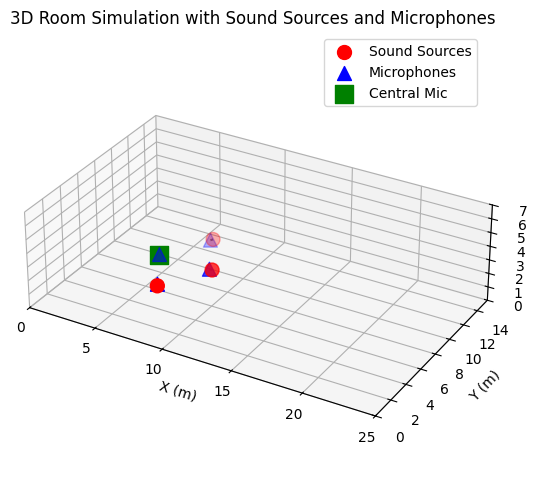

In [27]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import soundfile as sf

# parameters
audio_dir = "audio_dir"
audio_files = ["bass.wav", "drums.wav", "vocals.wav"]
room_dim = [25, 15.5, 7] # define room dimensions [m]
T60 = 1.8*2 # set reverb time (T60=2*T30)
num_sources = 3 
radius = 4  # radius to the central mic
# center = np.array([room_dim[0] / 2, room_dim[1] / 2, 1.5])
center = np.array([5, room_dim[1] / 2, 1.5])
mic_height = 1.5
mic_radius_diff = 0.2 # distance between mic to sound source [m]

# load wav files
audio_wavs = []
for i, audio_file in enumerate(audio_files):
    audio, fs = sf.read(f"{audio_dir}/{audio_file}")
    # Convert to mono if not already
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    audio_wavs.append(audio)

# create room and calculate absorption coefficients
absorption, max_order = pra.inverse_sabine(T60, room_dim)
room = pra.ShoeBox(room_dim, fs=44100, materials=pra.Material(absorption), max_order=max_order)

# calculate source positions' angles
angles = np.linspace(-np.pi / 3, np.pi / 3, num_sources)  # 120° 弧形分布

# set sound source positions
source_positions = np.array([
    [center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle), 1.5]
    for angle in angles
])

# add sound sources
for i, pos in enumerate(source_positions):
    room.add_source(pos, signal=audio_wavs[i])  

radius -= mic_radius_diff
mic_positions = np.vstack([
    np.array([
        [center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle), 1.5]
        for angle in angles
    ]),
    center.reshape(1, -1)  # cnetral mic
])

# plot 3D room
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
ax.scatter(source_positions[:, 0], source_positions[:, 1], source_positions[:, 2], 
           color='red', marker='o', s=100, label="Sound Sources")
ax.scatter(mic_positions[:, 0], mic_positions[:, 1], mic_positions[:, 2], 
           color='blue', marker='^', s=100, label="Microphones")
ax.scatter(center[0], center[1], center[2], 
           color='green', marker='s', s=150, label="Central Mic")
for i in range(num_sources):
    ax.plot([source_positions[i, 0], mic_positions[i, 0]],
            [source_positions[i, 1], mic_positions[i, 1]],
            [source_positions[i, 2], mic_positions[i, 2]],
            color='gray', linestyle='dashed')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("3D Room Simulation with Sound Sources and Microphones")
ax.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# add microphones
room.add_microphone_array(pra.MicrophoneArray(mic_positions.T, fs=room.fs))

room.compute_rir()  # calculate RIR
room.simulate()

# get reverb audio
recorded_signals = room.mic_array.signals  # shape: (num_mics, num_samples)

# save audio
for i, signal in enumerate(recorded_signals):
    sf.write(f"mic_{i}.wav", signal, room.fs)
